In [15]:
# Useful imports and setup
import sys
import os
# Necessary to import code from ../scripts/
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"/scripts")
    

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from preprocessing import preprocess
from cluster import *
from visualization import *

from baseline import baseline_model, train_model, train_val_split, print_metrics, get_metrics
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

%load_ext autoreload
%autoreload 2

MODEL_PATH = '../models/saved/'
labels_path = '../labels/'
results_path = '../results/'
clustering_method = 'spectral_clustering'

data_path = '../data/'
course = 'dsp_004'

MODEL_PATH += course + '/'
labels_path += course + '/' + clustering_method + '/'
results_path += course + '/'

if not os.path.exists(MODEL_PATH):
    os.makedirs(MODEL_PATH)
    
if not os.path.exists(labels_path):
    os.makedirs(labels_path)
    
if not os.path.exists(results_path):
    os.makedirs(results_path)

path = data_path + course + '/'
feature_types = ['lalle_conati', 'boroujeni_et_al', 'chen_cui', 'marras_et_al']
metadata = pd.read_csv(data_path + 'metadata.csv')
hard_fail = path + 'feature_labels.csv'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Spectral clustering - euclidean distance

In [16]:
gamma_list = [0.6]
for percentile in [0.2, 0.4, 0.6, 0.8]:
    x_train, x_test, x_val, y_train, y_test, y_val, feature_names = preprocess(course, path, percentile, feature_types, metadata)
    X = np.concatenate([x_train, x_val, x_test], axis=0)
    Y = np.concatenate([y_train, y_val, y_test], axis=0)
    print("Running for percentile {0}".format(percentile))
    D = compute_distance_matrix(X, 'euclidean')
    for gamma in gamma_list:
        print('Gamma: {0}'.format(gamma))
        S = np.exp(-gamma * D ** 2)
        n_clusters = eigengap(S)
        n = 0
        for i in n_clusters:
            if i > 2:
                n = i
                break
        print(n)
        labels = spectral_clustering(n).fit_predict(S)
        np.savetxt(labels_path+'baseline_perc_'+str(percentile)+'_gamma_'+str(gamma)+'.txt', labels, fmt='%d')

Running for percentile 0.2
Gamma: 0.6
3
Running for percentile 0.4
Gamma: 0.6
3
Running for percentile 0.6
Gamma: 0.6
3
Running for percentile 0.8
Gamma: 0.6
3


In [17]:
percentile = 0.6
x_train, x_test, x_val, y_train, y_test, y_val, feature_names = preprocess(course, path, percentile, feature_types, metadata)
X = np.concatenate([x_train, x_val, x_test], axis=0)
Y = np.concatenate([y_train, y_val, y_test], axis=0)
create_sankey_diagram(labels_path, 'baseline_perc_', [0.2, 0.4, 0.6, 0.8], Y, gamma=True, g=0.6)

X_flatten shape: (1735, 270)


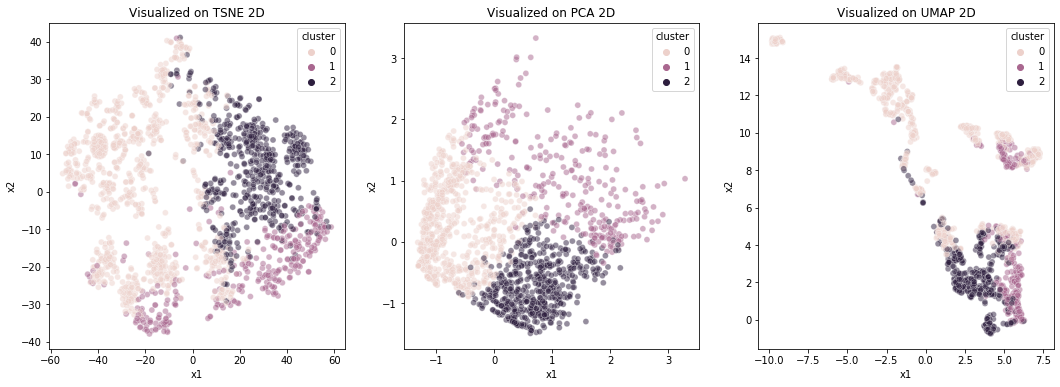

In [18]:
labels = np.loadtxt(labels_path+'baseline_perc_0.6_gamma_0.6.txt', dtype=int)
_, X_flatten, X, Y = get_x_flatten(course, path, percentile, feature_types, metadata)
plot_tsne_and_pca(X_flatten, labels)

### Baseline classification for each cluster

Using a baseline BiLSTM model and considering spectral clustering for 6 weeks

In [19]:
aucs = []
bal_accs = []
accs = []
for c in range(np.max(labels)+1):
    print('\n\nTraining predictions for cluster {0}'.format(c))
    
    idx = np.where(labels == c)[0]
    X_train = X[idx]
    Y_train = Y[idx]
    
    baseline_params = {
    'name': 'baseline-32u-1l',
    'optimizer': 'adam',
    'loss': 'binary_crossentropy',
    'metrics': ['binary_accuracy'],
    'epochs': 20,
    'batch_size': 64,
    'verbose': 1
    }
    baseline = baseline_model()

    x_train, x_val, y_train, y_val = train_val_split(X_train, Y_train)
    train_model(baseline, x_train, y_train, x_val, y_val, baseline_params)
    print_metrics(baseline, x_val, y_val)
    auc, bal_acc, acc = get_metrics(baseline, x_val, y_val)
    aucs.append(auc)
    bal_accs.append(bal_acc)
    accs.append(acc)
    baseline.save_weights(MODEL_PATH + 'baseline_classifier_for_cluster_'+str(c))



Training predictions for cluster 0
Epoch 1/20
13/13 [==============================] - 8s 173ms/step - loss: 0.6188 - binary_accuracy: 0.8506 - val_loss: 0.5225 - val_binary_accuracy: 0.9333
Epoch 2/20
13/13 [==============================] - 0s 7ms/step - loss: 0.4714 - binary_accuracy: 0.9141 - val_loss: 0.3667 - val_binary_accuracy: 0.9333
Epoch 3/20
13/13 [==============================] - 0s 7ms/step - loss: 0.3382 - binary_accuracy: 0.9141 - val_loss: 0.2511 - val_binary_accuracy: 0.9333
Epoch 4/20
13/13 [==============================] - 0s 7ms/step - loss: 0.2766 - binary_accuracy: 0.9141 - val_loss: 0.2136 - val_binary_accuracy: 0.9333
Epoch 5/20
13/13 [==============================] - 0s 8ms/step - loss: 0.2506 - binary_accuracy: 0.9141 - val_loss: 0.1889 - val_binary_accuracy: 0.9333
Epoch 6/20
13/13 [==============================] - 0s 7ms/step - loss: 0.2214 - binary_accuracy: 0.9141 - val_loss: 0.1660 - val_binary_accuracy: 0.9333
Epoch 7/20
13/13 [===================

8/8 [==============================] - 0s 8ms/step - loss: 0.2039 - binary_accuracy: 0.9115 - val_loss: 0.1313 - val_binary_accuracy: 0.9444
Epoch 13/20
8/8 [==============================] - 0s 8ms/step - loss: 0.1805 - binary_accuracy: 0.9239 - val_loss: 0.1127 - val_binary_accuracy: 0.9444
Epoch 14/20
8/8 [==============================] - 0s 8ms/step - loss: 0.1593 - binary_accuracy: 0.9300 - val_loss: 0.0944 - val_binary_accuracy: 0.9444
Epoch 15/20
8/8 [==============================] - 0s 10ms/step - loss: 0.1425 - binary_accuracy: 0.9383 - val_loss: 0.0808 - val_binary_accuracy: 0.9630
Epoch 16/20
8/8 [==============================] - 0s 7ms/step - loss: 0.1320 - binary_accuracy: 0.9383 - val_loss: 0.0727 - val_binary_accuracy: 0.9815
Epoch 17/20
8/8 [==============================] - 0s 7ms/step - loss: 0.1214 - binary_accuracy: 0.9383 - val_loss: 0.0655 - val_binary_accuracy: 0.9630
Epoch 18/20
8/8 [==============================] - 0s 7ms/step - loss: 0.1116 - binary_accura

In [20]:
df = pd.DataFrame()
df['AUC'] = aucs
df['Balanced ACC'] = bal_accs
df['ACC'] = accs

In [21]:
df.to_csv(results_path+'baseline_clusters_classifiers_metrics.csv', index=False)

In [22]:
df

,AUC,Balanced ACC,ACC
0,0.998016,0.916667,0.988889
1,0.852564,0.707265,0.709677
2,0.993464,0.823529,0.962963
